In [136]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from keras.optimizers import Adam
import datetime

In [137]:
df = pd.read_csv('/content/GBPJPY=X.csv')
df.tail(5)

,Date,Open,High,Low,Close,Adj Close,Volume
5213,2024-02-22,189.990005,190.811005,189.856995,189.990005,189.990005,0.0
5214,2024-02-23,190.539001,191.136993,190.386002,190.539001,190.539001,0.0
5215,2024-02-26,190.681000,191.300003,190.319000,190.707001,190.707001,0.0
5216,2024-02-27,190.940002,190.966003,190.403000,190.966995,190.966995,0.0
5217,2024-02-28,190.882004,190.938995,190.257996,190.550003,190.550003,0.0


In [138]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5205.000000,5205.000000,5205.000000,5205.000000,5205.000000,5205.0
mean,164.477829,165.222521,163.654668,164.472237,164.472237,0.0
std,31.103018,31.186255,31.013312,31.106057,31.106057,0.0
min,117.169998,117.735001,116.949997,117.180000,117.180000,0.0
25%,140.080002,140.766998,139.410004,140.080994,140.080994,0.0
50%,154.167999,154.785004,153.447998,154.179993,154.179993,0.0
75%,187.270004,187.949997,186.429993,187.158005,187.158005,0.0
max,250.339996,251.076004,249.772003,250.287003,250.287003,0.0


In [139]:
df.corr()['Close']

<ipython-input-139-8695f15c585d>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()['Close']


Open         0.999578
High         0.999632
Low          0.999601
Close        1.000000
Adj Close    1.000000
Volume            NaN
Name: Close, dtype: float64

In [140]:
df.dropna(inplace=True)

In [141]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5205 entries, 0 to 5217
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5205 non-null   object 
 1   Open       5205 non-null   float64
 2   High       5205 non-null   float64
 3   Low        5205 non-null   float64
 4   Close      5205 non-null   float64
 5   Adj Close  5205 non-null   float64
 6   Volume     5205 non-null   float64
dtypes: float64(6), object(1)
memory usage: 325.3+ KB


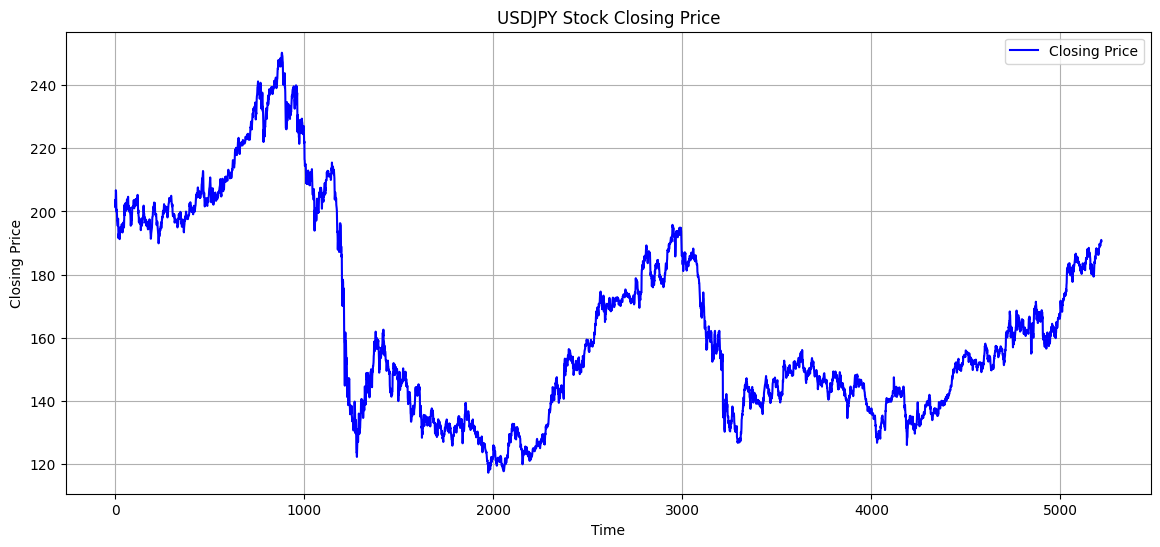

In [142]:
plt.figure(figsize=(14, 6),dpi = 100)
plt.plot(df['Close'], label='Closing Price', color='blue')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.title('USDJPY Stock Closing Price')
plt.legend()
plt.grid(True)
plt.show()

In [143]:
df2 = df.copy()

In [144]:
df2.set_index('Date', inplace=True)
data = df2['Close'].values.reshape(-1, 1)
data

array([[203.5     ],
       [202.419998],
       [201.240005],
       ...,
       [190.707001],
       [190.966995],
       [190.550003]])

In [145]:
data.shape

(5205, 1)

In [146]:
df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-03-01,204.410004,204.880005,203.080002,203.500000,203.500000,0.0
1,2004-03-02,203.490005,204.050003,202.000000,202.419998,202.419998,0.0
2,2004-03-03,202.460007,202.660004,200.000000,201.240005,201.240005,0.0
3,2004-03-04,201.259995,202.800003,200.770004,202.729996,202.729996,0.0
4,2004-03-05,202.710007,207.240005,201.970001,206.699997,206.699997,0.0


In [147]:
scaler = MinMaxScaler()
data = scaler.fit_transform(data)
data

array([[0.64850082],
       [0.64038703],
       [0.63152203],
       ...,
       [0.55239018],
       [0.55434345],
       [0.55121069]])

In [148]:
sequence_length = 30

X, y = [], []

for i in range(len(data) - sequence_length):
    X.append(data[i:i + sequence_length])
    y.append(data[i + sequence_length])

In [149]:
X = np.array(X)
y = np.array(y)

In [150]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [151]:
print('x_train',X_train.shape)
print('y_train',y_train.shape)
print('x_test',X_test.shape)
print('y_test',y_test.shape)

x_train (4140, 30, 1)
y_train (4140, 1)
x_test (1035, 30, 1)
y_test (1035, 1)


In [152]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))

In [153]:
model.compile(optimizer=Adam(learning_rate = 0.001), loss='mean_squared_error')
# early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
# model.fit(X_train, y_train, epochs=2, batch_size=32, validation_split=0.2, callbacks=[early_stopping]);
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
104/104 [==============================] - 24s 175ms/step - loss: 0.0211 - val_loss: 4.8169e-04
Epoch 2/100
104/104 [==============================] - 20s 190ms/step - loss: 0.0037 - val_loss: 4.8669e-04
Epoch 3/100
104/104 [==============================] - 10s 93ms/step - loss: 0.0030 - val_loss: 3.8955e-04
Epoch 4/100
104/104 [==============================] - 9s 88ms/step - loss: 0.0025 - val_loss: 3.1151e-04
Epoch 5/100
104/104 [==============================] - 9s 87ms/step - loss: 0.0022 - val_loss: 2.9336e-04
Epoch 6/100
104/104 [==============================] - 10s 94ms/step - loss: 0.0020 - val_loss: 3.2149e-04
Epoch 7/100
104/104 [==============================] - 10s 94ms/step - loss: 0.0019 - val_loss: 3.9133e-04
Epoch 8/100
104/104 [==============================] - 9s 89ms/step - loss: 0.0017 - val_loss: 2.5846e-04
Epoch 9/100
104/104 [==============================] - 10s 93ms/step - loss: 0.0015 - val_loss: 2.4440e-04
Epoch 10/100
104/104 [================

In [154]:
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

33/33 [==============================] - 2s 25ms/step


In [155]:
mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
accuracy = 100 - rmse
print("Percentage Accuracy: {:.2f}%".format(accuracy))

Percentage Accuracy: 96.99%


In [156]:
mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Squared Error (MSE): 9.056590560316867
Root Mean Squared Error (RMSE): 3.0094169801336714


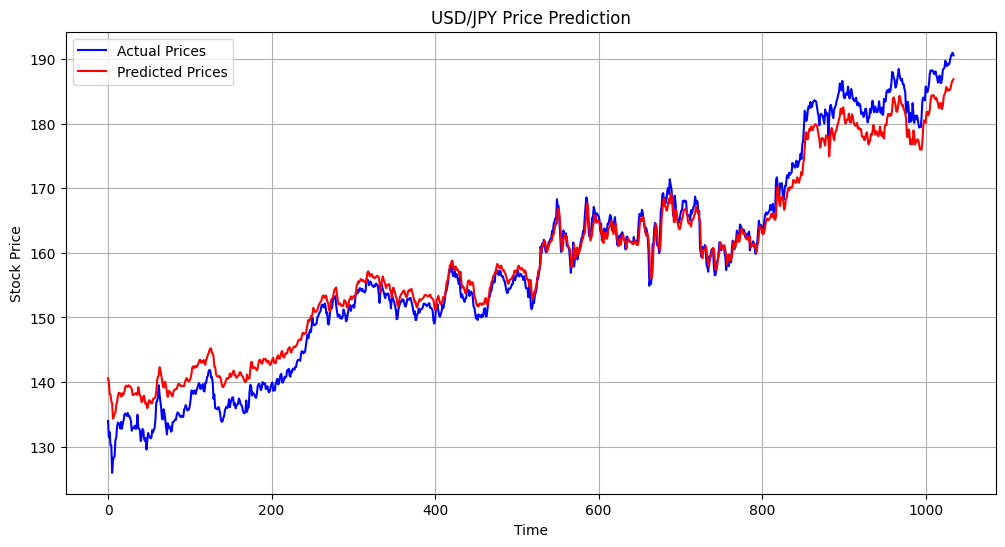

In [157]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Prices', color='blue')
plt.plot(y_pred, label='Predicted Prices', color='red')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('USD/JPY Price Prediction')
plt.legend()
plt.grid(True)
plt.show()

        Date  Predicted Price
0 2024-02-28       185.661438
1 2024-02-29       185.471939
2 2024-03-01       185.068298
3 2024-03-02       185.263809
4 2024-03-03       185.183212
5 2024-03-04       185.264297
6 2024-03-05       185.839417
7 2024-03-06       186.446228
8 2024-03-07       186.674026
9 2024-03-08       186.879196


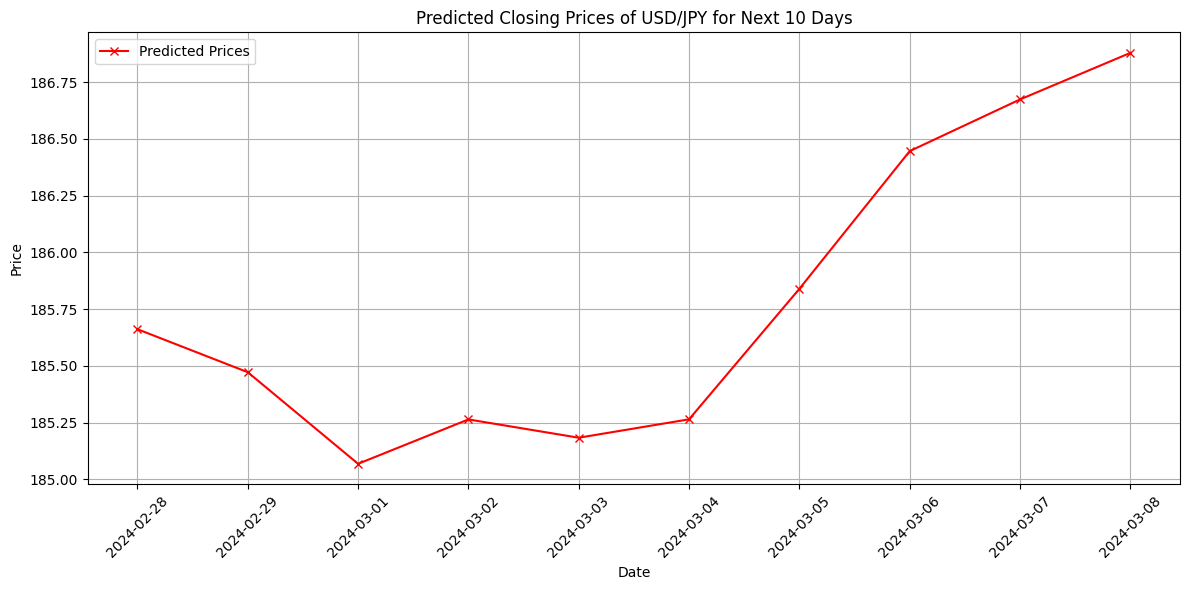

In [175]:
import datetime
targetday = 10
start_date = df['Date'].iloc[-1]
future_dates = pd.date_range(start=start_date, periods=targetday, freq='D')

future_days = len(future_dates)
X_future = X_test[-future_days:]

# Predict the closing prices for the next 10 days
y_pred = model.predict(X_future,verbose=0)
y_pred = scaler.inverse_transform(y_pred).flatten()

#DataFrame with the predicted closing prices and dates
prediction_df = pd.DataFrame({'Date': future_dates, 'Predicted Price': y_pred})
print(prediction_df)

plt.figure(figsize=(12, 6),dpi = 100)
plt.plot(prediction_df['Date'], prediction_df['Predicted Price'], label='Predicted Prices', color='red', marker='x')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Predicted Closing Prices of USD/JPY for Next 10 Days')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

DataFrame of Predicted Closing Prices for Next 10 Days:
   Day  Predicted Closing Price
0    1               186.350189
1    2               182.972687
2    3               179.340958
3    4               175.747314
4    5               172.264420
5    6               169.020050
6    7               166.184769
7    8               163.867950
8    9               162.106064
9   10               160.883621


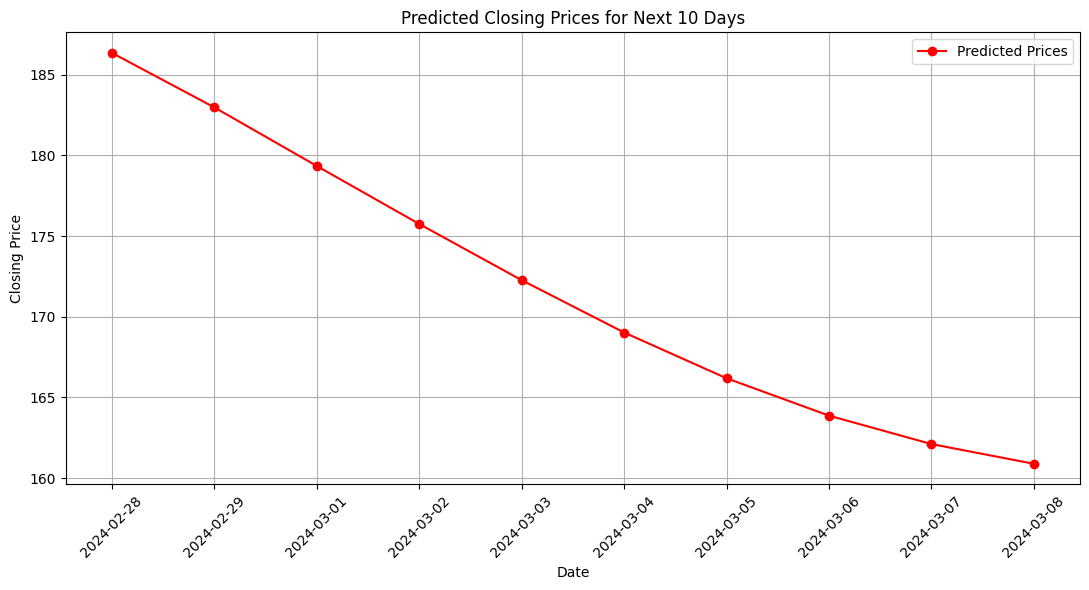

In [164]:
targetday = 10
start_date = df['Date'].iloc[-1]
dates = pd.date_range(start=start_date, periods=targetday, freq='D')
# Step 1: Prepare the input data for prediction
last_10_closing_prices = df['Close'].tail(targetday).values
input_data = last_10_closing_prices.reshape(-1, 1)  # Reshape to (1, 10),2D

# Step 2: Scale the input data
scaled_input_data = scaler.transform(input_data)

# Initialize an empty list to store predicted closing prices
predicted_prices = []

# Step 3-6: Predict the next 10 closing prices
for _ in range(targetday):
    # Step 3: Reshape the input data to match the input shape expected by the LSTM model
    reshaped_input_data = scaled_input_data.reshape(1, targetday, 1)  # Reshape to (1, 10, 1) for LSTM input,as sequence length was 10

    # Step 4: Use the LSTM model to predict the next closing price
    next_predicted_price = model.predict(reshaped_input_data, verbose=0)

    # Step 5: Inverse transform the predicted price to get the actual predicted value
    next_predicted_price_scaled = scaler.inverse_transform(next_predicted_price)[0][0] # as the prediction is like [[141.042]],2D

    # Step 6: Update input data by appending the predicted closing price
    input_data = np.append(input_data, next_predicted_price_scaled)
    input_data = input_data[-targetday:]  # Keep only the last  closing prices for the next prediction

    # Update scaled input data with the new predicted value
    scaled_input_data = scaler.transform(input_data.reshape(-1, 1))

    # Append the predicted closing price to the list
    predicted_prices.append(next_predicted_price_scaled)



#DataFrame with predicted closing prices
predicted_df = pd.DataFrame({'Day': range(1, targetday + 1), 'Predicted Closing Price': predicted_prices})
print("DataFrame of Predicted Closing Prices for Next 10 Days:")
print(predicted_df)


plt.figure(figsize=(11, 6))
plt.plot(dates, predicted_prices, marker='o', color='red', label='Predicted Prices')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Closing Price')
plt.title('Predicted Closing Prices for Next 10 Days')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [170]:
X_future

array([[[0.48098899],
        [0.49903457],
        [0.50228758],
        [0.50042441],
        [0.49882421],
        [0.51500673],
        [0.51182136],
        [0.50844053],
        [0.5122721 ],
        [0.51760609],
        [0.53011489],
        [0.53372854],
        [0.53282694],
        [0.53378862],
        [0.53299981],
        [0.5297092 ],
        [0.52985192],
        [0.53265418],
        [0.52801133],
        [0.52513387],
        [0.519627  ],
        [0.52181321],
        [0.52774836],
        [0.51928894],
        [0.51913121],
        [0.52442015],
        [0.53471269],
        [0.53574945],
        [0.53680869],
        [0.54504273]],

       [[0.49903457],
        [0.50228758],
        [0.50042441],
        [0.49882421],
        [0.51500673],
        [0.51182136],
        [0.50844053],
        [0.5122721 ],
        [0.51760609],
        [0.53011489],
        [0.53372854],
        [0.53282694],
        [0.53378862],
        [0.53299981],
        [0.5297092 ],
        

In [161]:
# # Load the trained model
# def load_trained_model(model_path):
#     model = load_model(model_path)
#     return model

# # Predict future prices
# def predict_future_prices(model, last_sequence, scaler, days=10):
#     predictions = []
#     for _ in range(days):
#         next_day = model.predict(last_sequence.reshape(1, last_sequence.shape[0], 1))
#         predictions.append(next_day[0][0])
#         last_sequence = np.roll(last_sequence, -1)
#         last_sequence[-1] = next_day
#     predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
#     return predictions

# # Main function to load model and predict
# def predict_future_prices_and_plot(model_path, data, days=10):
#     # Data preprocessing
#     closing_prices_scaled, scaler = preprocess_data(data)

#     # Load the trained model
#     model = load_trained_model(model_path)

#     # Get the last day's closing price from the dataset
#     last_sequence = closing_prices_scaled[-20:].reshape(20, 1)

#     # Predict future prices
#     future_predictions = predict_future_prices(model, last_sequence, scaler, days=days)

#     # Generate future dates for the next 10 days
#     last_date = pd.to_datetime(data['Date'].iloc[-1])
#     future_dates = [last_date + pd.Timedelta(days=i) for i in range(1, days + 1)]

#     # Plot the predicted closing prices for the next 10 days
#     plt.figure(figsize=(12, 6))
#     plt.plot(future_dates, future_predictions, label='Predicted Closing Price', marker='o', color='red')
#     plt.xlabel('Date')
#     plt.ylabel('Closing Price')
#     plt.title('Predicted Closing Prices for the Next 10 Days')
#     plt.xticks(rotation=45)
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

# # Entry point
# if __name__ == "__main__":
#     model_path = '/content/stock_price_prediction_model.h5'
#     predict_future_prices_and_plot(model_path, data)
